In [40]:
import os
import re
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
# to see the whole dataframe
pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.read_csv(r"C:\Users\Cyrus\Documents\Data Projects\bbc nlp\data\tech\tech.csv")
# Check dataset
df

Category  \
0       tech   
1       tech   
2       tech   
3       tech   
4       tech   
..       ...   
396     tech   
397     tech   
398     tech   
399     tech   
400     tech   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [43]:
df.head()

Category  \
0     tech   
1     tech   
2     tech   
3     tech   
4     tech   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [44]:
# Check dataset shape
print("Shape:", df.shape)

# Null values
print("\nNull values:")
print(df.isnull().sum())

# Duplicate rows
print("\nDuplicates:", df.duplicated().sum())

# Count duplicates only in the Text column
dup_text_count = df["Text"].duplicated().sum()
print("Duplicate Text rows:", dup_text_count)

# Show the actual duplicate texts (if any)
dup_texts = df[df["Text"].duplicated(keep=False)].sort_values("Text")
print(dup_texts)



Shape: (401, 4)

Null values:
Category         0
Text             0
Filename         0
Subcategory    401
dtype: int64

Duplicates: 0
Duplicate Text rows: 54
    Category  \
164     tech   
165     tech   
125     tech   
170     tech   
168     tech   
..       ...   
26      tech   
311     tech   
89      tech   
93      tech   
312     tech   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Remove Duplicate Texts

In [45]:
# Drop duplicates in the Text column, keep first occurrence
df = df.drop_duplicates(subset=["Text"]).reset_index(drop=True)

print("After dropping duplicate texts:", df.shape)
print("Remaining duplicates in Text:", df["Text"].duplicated().sum())


After dropping duplicate texts: (347, 4)
Remaining duplicates in Text: 0


Filter Out Very Short News

In [46]:
# Add word count column
df["word_count"] = df["Text"].apply(lambda x: len(x.split()))

# Drop very short texts (e.g., < 30 words)
df = df[df["word_count"] > 30].reset_index(drop=True)

print("After filtering short docs:", df.shape)

After filtering short docs: (347, 5)


Data Cleaning 

In [ ]:
import re

# Clean text
def clean_text(text):
    """
    Lightly cleans raw news text for embeddings:
    - Removes extra line breaks/tabs
    - Normalizes common quotes/apostrophes
    - Keeps punctuation (! ? : ; - / @ &) since LLM embeddings benefit from context
    - Collapses multiple spaces
    """
    # 1. Remove line breaks & tabs
    text = text.replace("\n", " ").replace("\t", " ")

    # 2. Normalize quotes/apostrophes
    text = re.sub(r"[“”]", '"', text)
    text = re.sub(r"[‘’]", "'", text)

    # 3. Keep most punctuation, only strip weird unicode
    text = re.sub(r"[^\x00-\x7F]+", " ", text)  # remove non-ASCII symbols

    # 4. Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


# Apply function to df
def clean_dataframe(df):
    if "Text" not in df.columns:
        raise KeyError("DataFrame must have a 'Text' column")

    df["Clean_Text"] = df["Text"].astype(str).apply(clean_text)
    df = df[df["Clean_Text"].str.strip() != ""].reset_index(drop=True)

    return df


# Example Run
df_clean = clean_dataframe(df)
print(df_clean[["Category", "Clean_Text"]].head(3))


  Category  \
0     tech   
1     tech   
2     tech   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [48]:
df.head()

Category  \
0     tech   
1     tech   
2     tech   
3     tech   
4     tech   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
# Use GPU
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


Embedding each article with OpenAI

In [ ]:
import pandas as pd
import hdbscan
from sklearn.metrics.pairwise import cosine_distances
from openai import OpenAI
import json
import random

# Setup client
client = OpenAI(api_key="")


# ---------- Embedding ----------
def get_embedding(text, model="text-embedding-3-large"):
    response = client.embeddings.create(input=text, model=model)
    return response.data[0].embedding


#Labeling with GPT (Tech)
def label_cluster(docs):
    """Label a group of technology documents with broad reusable categories"""
    sample_text = "\n---\n".join(docs[:3])  # up to 3 docs
    prompt = f"""
You are a topic labeling assistant. 
Your task is to assign a broad, reusable subtopic label.

Here are some example technology news articles from the same cluster:
{sample_text}

Guidelines:
- Labels must be broad enough to apply to many similar texts.  
- Use general categories such as:
  "AI", "Cybersecurity", "Software", "Hardware", "Semiconductors", "Cloud",
  "Startups", "Venture Capital", "Internet Policy", "Social Media",
  "Consumer Tech", "Gadgets", "Data Privacy", "Telecom", "Regulation"
- Avoid overly specific product names or one-off event labels.  
- Keep labels 1–3 words maximum.  
- Prefer terms that can group other articles in the same domain.  

Respond in JSON format: {{"label": "your label here"}}
"""
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    try:
        return json.loads(response.choices[0].message.content)["label"]
    except:
        return response.choices[0].message.content.strip()


def label_single_doc(text):
    """Label a single technology article with predefined categories, with flexibility for new ones"""
    first_sentence = text.split(".")[0]
    prompt = f"""You are a topic labeling assistant.
Your task is to assign a broad reusable subtopic label for a technology news article.

Here is a news snippet:
{first_sentence}

Guidelines:
- Prefer one of these predefined tech categories if possible:
  ["AI", "Cybersecurity", "Software", "Hardware", "Semiconductors", "Cloud",
   "Startups", "Venture Capital", "Internet Policy", "Social Media",
   "Consumer Tech", "Gadgets", "Data Privacy", "Telecom", "Regulation"]
- If the text does not fit any of these, propose a concise new label (1–3 words).  
- Keep labels broad, reusable, and no more than 3 words.  
- Avoid product-specific or one-off names.

Respond in JSON format: {{"label": "your label here"}}
"""
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    try:
        return json.loads(response.choices[0].message.content)["label"]
    except:
        return response.choices[0].message.content.strip()



In [ ]:
# Main loop
results = []

for cat, group in df.groupby("Category"):
    print(f"\nProcessing category: {cat}, n={len(group)}")

    # Step 1: Embeddings
    group["embedding"] = group["Clean_Text"].apply(get_embedding)
    X = np.array(group["embedding"].to_list())

    # Step 2: Cosine distance
    cosine_dist = cosine_distances(X)

    # Step 3: HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=5,
        min_samples=3,
        metric="precomputed",
        cluster_selection_method="leaf"
    )
    group["Subcluster"] = clusterer.fit_predict(cosine_dist)

    # Step 4: Label clusters
    cluster_labels = {}
    for cluster_id in set(group["Subcluster"]):
        docs = group[group["Subcluster"] == cluster_id]["Clean_Text"].tolist()
        
        if cluster_id == -1:  
            # Noise → label individually
            for idx, doc in group[group["Subcluster"] == -1].iterrows():
                group.at[idx, "Subtopic_Label"] = label_single_doc(doc["Clean_Text"])
        else:
            # Label real clusters
            sample_docs = random.sample(docs, min(3, len(docs)))
            cluster_labels[cluster_id] = label_cluster(sample_docs)
            group.loc[group["Subcluster"] == cluster_id, "Subtopic_Label"] = cluster_labels[cluster_id]

    results.append(group)

# Final combined dataframe
df_subtopics = pd.concat(results).reset_index(drop=True)

# Preview
print(df_subtopics[["Category", "Subcluster", "Subtopic_Label", "Clean_Text"]].head(20))





Processing category: tech, n=347
   Category  Subcluster       Subtopic_Label  \
0      tech          -1  Election Technology   
1      tech          -1      Internet Policy   
2      tech          -1        Cybersecurity   
3      tech          -1        Consumer Tech   
4      tech          -1  Creative Technology   
5      tech          -1              Telecom   
6      tech          -1        Cybersecurity   
7      tech          -1        Cybersecurity   
8      tech          -1              Gadgets   
9      tech           0      Internet Policy   
10     tech          -1      Internet Policy   
11     tech          -1             Software   
12     tech          -1        Consumer Tech   
13     tech           3           Regulation   
14     tech          -1        Consumer Tech   
15     tech          -1      Internet Policy   
16     tech          -1        Consumer Tech   
17     tech          -1             Hardware   
18     tech          -1       Semiconductors   
19    

In [52]:
summary = df_subtopics.groupby(["Category", "Subtopic_Label"]).size().reset_index(name="Count")
print(summary.sort_values("Count", ascending=False).head(20))


   Category                            Subtopic_Label  Count
2      tech                             Consumer Tech    107
38     tech                                   Telecom     58
21     tech                           Internet Policy     42
4      tech                             Cybersecurity     36
29     tech                                Regulation     12
34     tech                                  Software     11
33     tech                              Social Media      9
41     tech  ```json\n{"label": "Cybersecurity"}\n```      9
14     tech                                  Hardware      7
5      tech                              Data Privacy      6
10     tech                                   Gadgets      4
32     tech                            Semiconductors      4
0      tech                                        AI      3
1      tech                                     Cloud      3
12     tech                           Gaming Industry      3
36     tech             

In [53]:
top_subtopics = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)

# Get top 5 per category
top5_per_category = top_subtopics.groupby("Category").head(5)
print(top5_per_category)


   Category   Subtopic_Label  Count
2      tech    Consumer Tech    107
38     tech          Telecom     58
21     tech  Internet Policy     42
4      tech    Cybersecurity     36
29     tech       Regulation     12


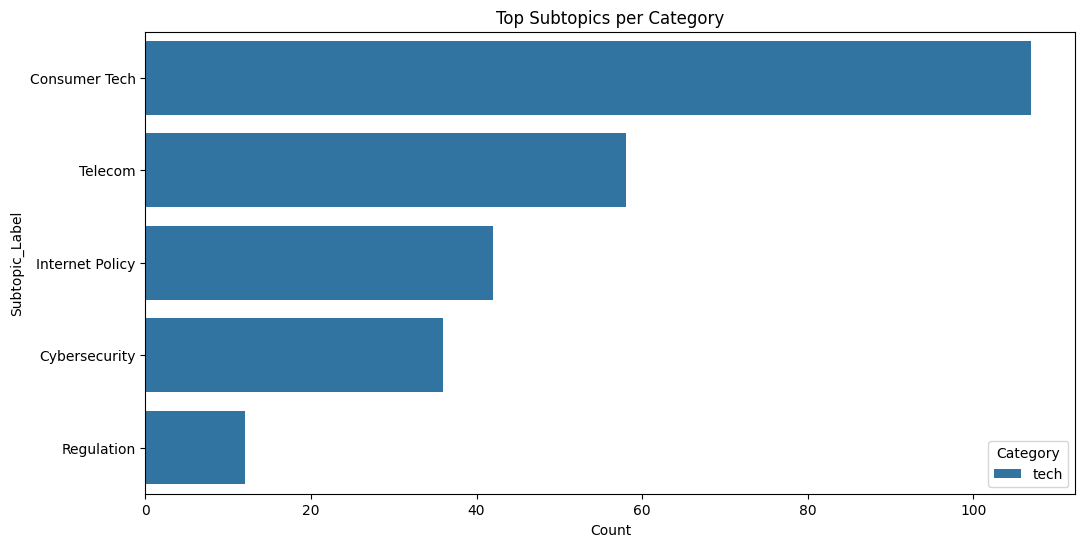

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(
    data=top5_per_category,
    x="Count", y="Subtopic_Label", hue="Category"
)
plt.title("Top Subtopics per Category")
plt.show()


We can regex clean those:

In [56]:
import re

def clean_label(label):
    if not isinstance(label, str):
        return label
    # If GPT returned JSON-like text, extract inside
    match = re.search(r'"label"\s*:\s*"([^"]+)"', label)
    if match:
        return match.group(1)
    return label.strip()

df_subtopics["Subtopic_Label"] = df_subtopics["Subtopic_Label"].apply(clean_label)

Rerunning the summary

In [57]:
summary = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)

top5_per_category = summary.groupby("Category").head(5)
print(top5_per_category)


   Category   Subtopic_Label  Count
2      tech    Consumer Tech    107
38     tech          Telecom     58
4      tech    Cybersecurity     45
21     tech  Internet Policy     42
29     tech       Regulation     12


save the full results into a DataFrame and export to CSV for further analysis or visualization.

In [58]:
import pandas as pd

# Ensure df_subtopics already has:
# Category, Subcluster, Subtopic_Label, Clean_Text

# Save the full detailed dataset
df_subtopics.to_csv("bbc_tech_subtopics_full.csv", index=False)

# Also save the summarized counts per category/subtopic
summary = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)
summary.to_csv("bbc_tech_subtopics_summary.csv", index=False)

print("✅ Files saved:")
print(" - bbc_subtopics_full.csv  (all rows with labels)")
print(" - bbc_subtopics_summary.csv  (aggregated counts)")


✅ Files saved:
 - bbc_subtopics_full.csv  (all rows with labels)
 - bbc_subtopics_summary.csv  (aggregated counts)
